In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose


from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Activation 
from tensorflow.keras.layers import BatchNormalization 


from tensorflow.keras.datasets import cifar10


import tensorflow.keras.backend as K


from tensorflow.keras.optimizers.schedules import CosineDecay




In [ ]:


channel = 64        
epochs = 10000      
batch_size = 128    


new_tx_lr = 1e-5

new_rx_lr = 1e-4  


sigma_sq = 1e-4 


UWA_TAPS = np.array([1.0]) 

print(f"--- Parameters Set for 'Asymmetric' (Shallow Tx, Deep Rx) Experiment ---")
print(f"Channel Capacity (k): {channel}")
print(f"Epochs: {epochs}")
print(f"Tx Learning Rate (initial): {new_tx_lr}")
print(f"Rx Learning Rate: {new_rx_lr}")
print(f"Channel Model: NOISE-ONLY (AWGN)")

In [ ]:
print("Loading CIFAR-10 dataset...")
(image_dataset_0_255, _), (_, _) = cifar10.load_data()


image_dataset_norm = image_dataset_0_255 / 255.0

print(f"Dataset loaded. Shape: {image_dataset_norm.shape}")
print(f"Pixel range: {np.min(image_dataset_norm)} to {np.max(image_dataset_norm)}")

Loading CIFAR-10 dataset...
Dataset loaded. Shape: (50000, 32, 32, 3)
Pixel range: 0.0 to 1.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPool2D, Flatten, Dense, Reshape, Lambda,
    Concatenate, UpSampling2D, Conv2DTranspose, Add, Activation,
    PReLU, BatchNormalization
)
from tensorflow.keras import backend as K
import keras
import numpy as np
from tensorflow.keras.optimizers.schedules import CosineDecay


class GDN(tf.keras.layers.Layer):
    def __init__(self, inverse=False, beta_min=1e-6, gamma_init=0.1, **kwargs):
        super(GDN, self).__init__(**kwargs)
        self.inverse = inverse
        self.beta_min = beta_min
        self.gamma_init = gamma_init

    def build(self, input_shape):
        channels = int(input_shape[-1])
        self.beta = self.add_weight(
            name="beta",
            shape=(channels,),
            initializer=tf.keras.initializers.Constant(1.0),
            trainable=True,
        )
        self.gamma = self.add_weight(
            name="gamma",
            shape=(channels, channels),
            initializer=tf.keras.initializers.Identity(gain=self.gamma_init),
            trainable=True,
        )
        super(GDN, self).build(input_shape)

    def call(self, x):
        beta = tf.maximum(self.beta, self.beta_min)
        gamma = tf.square(self.gamma)
        norm = tf.sqrt(
            tf.nn.conv2d(
                tf.square(x),
                tf.reshape(gamma, [1, 1, x.shape[-1], x.shape[-1]]),
                strides=[1, 1, 1, 1],
                padding="SAME",
            )
            + beta
        )
        return x * norm if self.inverse else x / norm


print(f"--- Setting up Schedulers & Helpers ---")
lr_schedule = CosineDecay(
    initial_learning_rate=new_tx_lr,
    decay_steps=epochs,
    alpha=0.0,
)


def perturbation(x):
    stddev = tf.cast(sigma_sq**0.5, tf.float32)
    w = K.random_normal(shape=K.shape(x), mean=0.0, stddev=stddev)
    multiplier = tf.cast((1 - sigma_sq) ** 0.5, tf.float32)
    return multiplier * x + w

def loss_tx(y_true_loss, y_pred_policy):
    return -y_true_loss * y_pred_policy

def get_policy(inp):
    xp, x = inp
    w = xp - x
    denom = tf.cast(2 * sigma_sq, tf.float32)
    return -K.sum(w * w, axis=[1, 2]) / denom

def channel_uwa(x_batch, taps, noise_std):
    y_batch = []
    for x in x_batch:
        noise = np.random.normal(0, noise_std, x.shape)
        y_batch.append(x + noise)
    return np.array(y_batch).astype("float32")

def paper_loss(y_true, y_pred):
    x_initial, x_final = y_pred
    l_init = tf.reduce_mean(tf.square(y_true - x_initial))
    l_final = tf.reduce_mean(tf.square(y_true - x_final))
    return l_init + l_final

def paper_loss_per_item(y_true, y_pred):
    x_final = y_pred[1]
    return tf.reduce_mean(tf.square(y_true - x_final), axis=(1, 2, 3))


print("Building *SHALLOW* Transmitter (Encoder)...")
total_channel = channel
lf_channel = 16
hf_channel = 48

tx_inp = Input(shape=(32, 32, 3))

x_enc = Conv2D(64, (5, 5), padding="same", strides=2)(tx_inp)
x_enc = GDN(inverse=False)(x_enc)
x_enc = PReLU(shared_axes=[1, 2])(x_enc)

x_enc = Conv2D(32, (5, 5), padding="same", strides=2)(x_enc)
x_enc = GDN(inverse=False)(x_enc)
x_enc = PReLU(shared_axes=[1, 2])(x_enc)

hf_flat = Flatten()(x_enc)
hf_dense = Dense(2 * hf_channel, activation="relu")(hf_flat)
hf_signal = Reshape((hf_channel, 2))(hf_dense)

lf_enc = Conv2D(16, (5, 5), padding="same", strides=2)(x_enc)
lf_enc = GDN(inverse=False)(lf_enc)
lf_enc = PReLU(shared_axes=[1, 2])(lf_enc)
lf_flat = Flatten()(lf_enc)
lf_dense = Dense(2 * lf_channel, activation="relu")(lf_flat)
lf_signal = Reshape((lf_channel, 2))(lf_dense)

to_complex = Concatenate(axis=1)([lf_signal, hf_signal])
x = Lambda(lambda z: K.l2_normalize(z, axis=-1))(to_complex)
xp = Lambda(perturbation)(x)
policy = Lambda(get_policy)([xp, x])

model_policy = keras.models.Model(inputs=tx_inp, outputs=policy, name="Policy_Model")
model_tx = keras.models.Model(inputs=tx_inp, outputs=xp, name="Signal_Tx_Model")
model_x = keras.models.Model(inputs=tx_inp, outputs=x, name="Clean_Signal_Model")

print(model_policy.summary())


def residual_block(x, filters, kernel_size=(3, 3), strides=1):
    shortcut = x
    if strides > 1 or x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    y = Conv2D(filters, kernel_size, padding="same")(y)
    y = BatchNormalization()(y)

    y = Add()([shortcut, y])
    return Activation("relu")(y)

def build_receiver_asymmetric(total_channel_in, lf_channel_in):
    hf_channel_in = total_channel_in - lf_channel_in
    print("Building *DEEP* Asymmetric Receiver (Decoder)...")
    rx_inp = Input(shape=(total_channel_in, 2))

    lf_signal_in = Lambda(lambda z: z[:, :lf_channel_in, :])(rx_inp)
    lf_flat_in = Flatten()(lf_signal_in)
    hf_signal_in = Lambda(lambda z: z[:, lf_channel_in:, :])(rx_inp)
    hf_flat_in = Flatten()(hf_signal_in)

    lf_dense_in = Dense(4 * 4 * 16, activation="relu")(lf_flat_in)
    lf_unflat = Reshape((4, 4, 16))(lf_dense_in)
    lf_up = Conv2DTranspose(32, (5, 5), strides=2, padding="same")(lf_unflat)
    lf_up = GDN(inverse=True)(lf_up)
    lf_up = PReLU(shared_axes=[1, 2])(lf_up)

    hf_dense_in = Dense(8 * 8 * 32, activation="relu")(hf_flat_in)
    hf_unflat = Reshape((8, 8, 32))(hf_dense_in)

    combined_decode = Concatenate()([lf_up, hf_unflat])
    x_dec = Conv2D(64, (5, 5), padding="same")(combined_decode)
    x_dec = GDN(inverse=True)(x_dec)
    x_dec = PReLU(shared_axes=[1, 2])(x_dec)

    x_dec = Conv2DTranspose(32, (5, 5), strides=2, padding="same")(x_dec)
    x_dec = GDN(inverse=True)(x_dec)
    x_dec = PReLU(shared_axes=[1, 2])(x_dec)

    x_dec = Conv2DTranspose(16, (5, 5), strides=2, padding="same")(x_dec)
    x_dec = GDN(inverse=True)(x_dec)
    x_dec = PReLU(shared_axes=[1, 2])(x_dec)

    x_initial = Conv2D(3, (5, 5), activation="sigmoid", padding="same", name="initial_output")(x_dec)

    x_deep = residual_block(x_initial, 64)
    x_deep = residual_block(x_deep, 64)
    x_deep = residual_block(x_deep, 64)

    x_correction = Conv2D(3, (3, 3), activation="tanh", padding="same")(x_deep)
    x_final = Add(name="final_output")([x_initial, x_correction])
    x_final = Lambda(lambda z: K.clip(z, 0.0, 1.0))(x_final)

    return keras.models.Model(inputs=rx_inp, outputs=[x_initial, x_final], name="Receiver_Model")

model_receiver = build_receiver_asymmetric(total_channel, lf_channel)
print(model_receiver.summary())


print("--- Compiling models with stability fixes ---")
optimizer_tx = tf.keras.optimizers.SGD(learning_rate=lr_schedule, clipnorm=1.0)
optimizer_rx = tf.keras.optimizers.Adam(learning_rate=new_rx_lr, clipnorm=1.0)

model_policy.compile(loss=loss_tx, optimizer=optimizer_tx)
print("\n--- Compiling Asymmetric Receiver with PAPER'S COMBINED MSE LOSS ---")
model_receiver.compile(loss=paper_loss, optimizer=optimizer_rx)

print("--- All models defined and compiled successfully. ---")


--- Setting up Schedulers & Helpers ---
--- All Helper & 'Paper Loss' functions defined ---
Building *SHALLOW* Transmitter (Encoder)...


Model: "Policy_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │      4,864 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_5 (GDN)         │ (None, 16, 16,    │      4,160 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 16, 16,    │         64 │ gdn_5[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 32)  │     51,232 │ p_re_lu[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_6 (GDN)         │ (None, 8, 8, 32)  │      1,056 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 8, 8, 32)  │         32 │ gdn_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 16)  │     12,816 │ p_re_lu_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_7 (GDN)         │ (None, 4, 4, 16)  │        272 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 4, 4, 16)  │         16 │ gdn_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 256)       │          0 │ p_re_lu_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ p_re_lu_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      8,224 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 96)        │    196,704 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 16, 2)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 48, 2)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 2)     │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64, 2)     │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64, 2)     │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None)            │          0 │ lambda_1[0][0],   │
│                     │                   │            │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 279,440 (1.07 MB)

 Trainable params: 279,440 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

None
Building *DEEP* Asymmetric Receiver (Decoder)...


Model: "Receiver_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 16, 2)     │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │      8,448 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 4, 4, 16)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 48, 2)     │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 32)  │     12,832 │ reshape_2[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 96)        │          0 │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_8 (GDN)         │ (None, 8, 8, 32)  │      1,056 │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2048)      │    198,656 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, 8, 8, 32)  │         32 │ gdn_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 8, 8, 32)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8, 64)  │          0 │ p_re_lu_3[0][0],  │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │    102,464 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_9 (GDN)         │ (None, 8, 8, 64)  │      4,160 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, 8, 8, 64)  │         64 │ gdn_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │     51,232 │ p_re_lu_4[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_10 (GDN)        │ (None, 16, 16,    │      1,056 │ conv2d_transpose… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_5 (PReLU)   │ (None, 16, 16,    │         32 │ gdn_10[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │     12,816 │ p_re_lu_5[0][0]   │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_11 (GDN)        │ (None, 32, 32,    │        272 │ conv2d_transpose… │
│                     │ 16)               │            │                 

 Total params: 584,550 (2.23 MB)

 Trainable params: 583,654 (2.23 MB)

 Non-trainable params: 896 (3.50 KB)

None
--- Compiling models with stability fixes ---

--- Compiling Asymmetric Receiver with PAPER'S COMBINED MSE LOSS ---
--- All models defined and compiled successfully. ---


In [ ]:
import tensorflow as tf
import numpy as np
import time
import csv  


GLOBAL_BATCH_SIZE = batch_size
print(f"Global batch size: {GLOBAL_BATCH_SIZE}")


image_dataset_norm = image_dataset_norm.astype('float32') 
train_dataset = tf.data.Dataset.from_tensor_slices(image_dataset_norm)
train_dataset = train_dataset.shuffle(50000).batch(GLOBAL_BATCH_SIZE).repeat() 
train_iterator = iter(train_dataset)



@tf.function
def tf_channel_uwa(x_batch):
    output_shape = x_batch.shape
    y_batch = tf.py_function(
        func=channel_uwa, 
        inp=[x_batch, UWA_TAPS, sigma_sq**0.5], 
        Tout=tf.float32
    )
    y_batch.set_shape(output_shape)
    return y_batch




@tf.function
def train_rx_step(batch_images):
    clean_signal = model_x(batch_images, training=False)
    y_rx = tf_channel_uwa(clean_signal)
    
    with tf.GradientTape() as tape:
        pred_images_list = model_receiver(y_rx, training=True)
        
        
        loss = paper_loss(batch_images, pred_images_list)
        
    grads = tape.gradient(loss, model_receiver.trainable_variables)
    optimizer_rx.apply_gradients(zip(grads, model_receiver.trainable_variables))
    

    initial_loss = tf.reduce_mean(tf.square(batch_images - pred_images_list[0]))
    final_loss = tf.reduce_mean(tf.square(batch_images - pred_images_list[1]))
    return initial_loss, final_loss

@tf.function
def train_tx_step(batch_images):
    xp = model_tx(batch_images, training=False)
    y_tx = tf_channel_uwa(xp)
    pred_images_list = model_receiver(y_tx, training=False)
    
    loss_per_item = paper_loss_per_item(batch_images, pred_images_list)
    
    with tf.GradientTape() as tape:
        policy = model_policy(batch_images, training=True)
        loss = loss_tx(loss_per_item, policy)
        avg_loss = tf.reduce_mean(loss)

    grads = tape.gradient(avg_loss, model_policy.trainable_variables)
    optimizer_tx.apply_gradients(zip(grads, model_policy.trainable_variables))
    
    return tf.reduce_mean(loss_per_item)




loss_tx_history = []
loss_rx_history = []
loss_rx_final_history = [] 

log_csv_path = "/kaggle/working/training_log.csv"
print(f"--- Training log will be saved to: {log_csv_path} ---")

csv_file = open(log_csv_path, 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["Epoch", "Tx_Score", "Rx_Loss_Initial", "Rx_Loss_Final"])

for epoch in range(epochs):
    
    try:
        tx_batch = next(train_iterator)
        tx_score_val = train_tx_step(tx_batch)
        
        rx_batch = next(train_iterator)
        rx_loss_initial_val, rx_loss_final_val = train_rx_step(rx_batch)

        loss_tx_history.append(tx_score_val.numpy()) 
        loss_rx_history.append(rx_loss_initial_val.numpy()) 
        loss_rx_final_history.append(rx_loss_final_val.numpy()) 

        if(epoch % 100 == 0):
            current_tx_score = loss_tx_history[-1]
            current_rx_loss_initial = loss_rx_history[-1]
            current_rx_loss_final = loss_rx_final_history[-1]
            
            print(f"Epoch: {epoch}, Tx Score: {current_tx_score:.4f}, Rx Loss (Initial): {current_rx_loss_initial:.4f}, Rx Loss (Final): {current_rx_loss_final:.4f}")
            
            csv_writer.writerow([epoch, current_tx_score, current_rx_loss_initial, current_rx_loss_final])
            csv_file.flush() 
        
    except Exception as e:
        print(f"Error in epoch {epoch}: {e}")
        print(f"Error type: {type(e)}")
        break 

print("\n--- Final Training Done. ---")
csv_file.close()
print(f"--- Training log successfully saved to {log_csv_path} ---")


Global batch size: 128

--- Starting Final Experiment (Asymmetric + Paper's Loss + GradientTape) ---
--- WARNING: Checkpoints are DISABLED. No models will be saved. ---
--- Training log will be saved to: /kaggle/working/training_log.csv ---
Epoch: 0, Tx Score: 0.2313, Rx Loss (Initial): 0.0664, Rx Loss (Final): 0.2264
Epoch: 100, Tx Score: 0.0771, Rx Loss (Initial): 0.0648, Rx Loss (Final): 0.1179
Epoch: 200, Tx Score: 0.1065, Rx Loss (Initial): 0.0651, Rx Loss (Final): 0.1014
Epoch: 300, Tx Score: 0.2228, Rx Loss (Initial): 0.0651, Rx Loss (Final): 0.1009
Epoch: 400, Tx Score: 0.2666, Rx Loss (Initial): 0.0574, Rx Loss (Final): 0.0947
Epoch: 500, Tx Score: 0.2582, Rx Loss (Initial): 0.0640, Rx Loss (Final): 0.0933
Epoch: 600, Tx Score: 0.2271, Rx Loss (Initial): 0.0664, Rx Loss (Final): 0.0899
Epoch: 700, Tx Score: 0.1081, Rx Loss (Initial): 0.0617, Rx Loss (Final): 0.0873
Epoch: 800, Tx Score: 0.1467, Rx Loss (Initial): 0.0631, Rx Loss (Final): 0.0884
Epoch: 900, Tx Score: 0.1429, Rx


--- Running Final Prediction and Visualization ---
--- Using models currently in notebook memory... ---
--- Images reconstructed. Plotting... ---

--- Similarity for this batch (10 images) ---
  Mean Squared Error (MSE):   0.045859 (Lower is better)
  PSNR (Peak Signal-to-Noise): 13.73 dB (Higher is better)
  Structural Similarity (SSIM): 0.354015 (Higher is better)
--------------------------------------------------


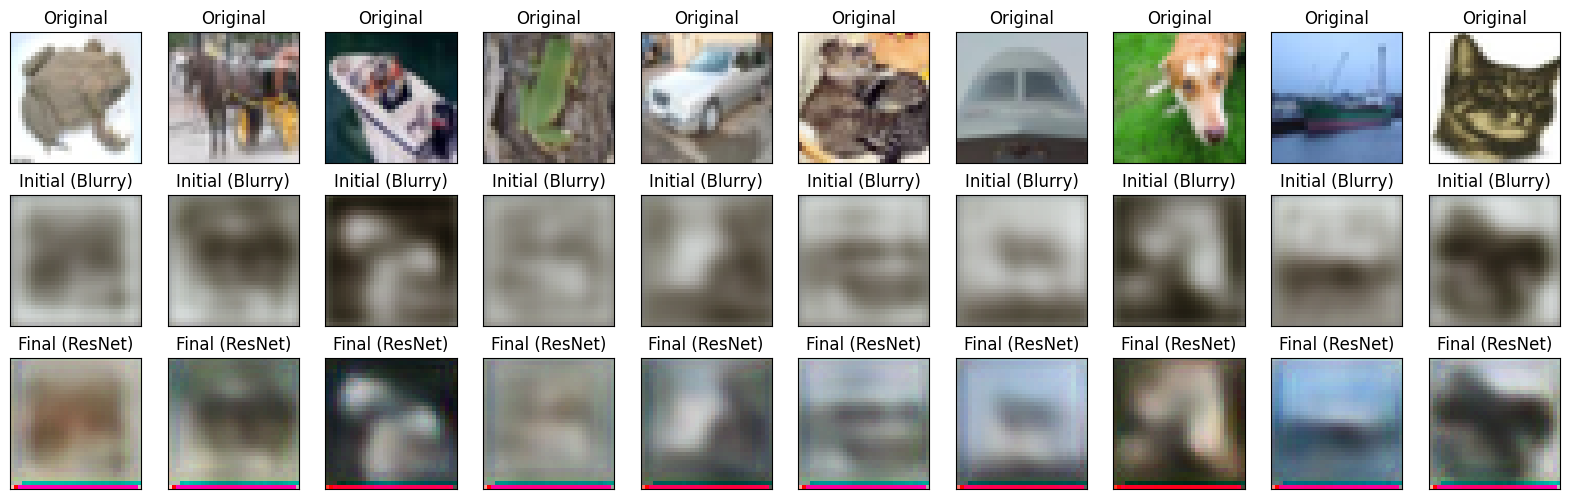


--- Plotting Loss History from training_log.csv ---


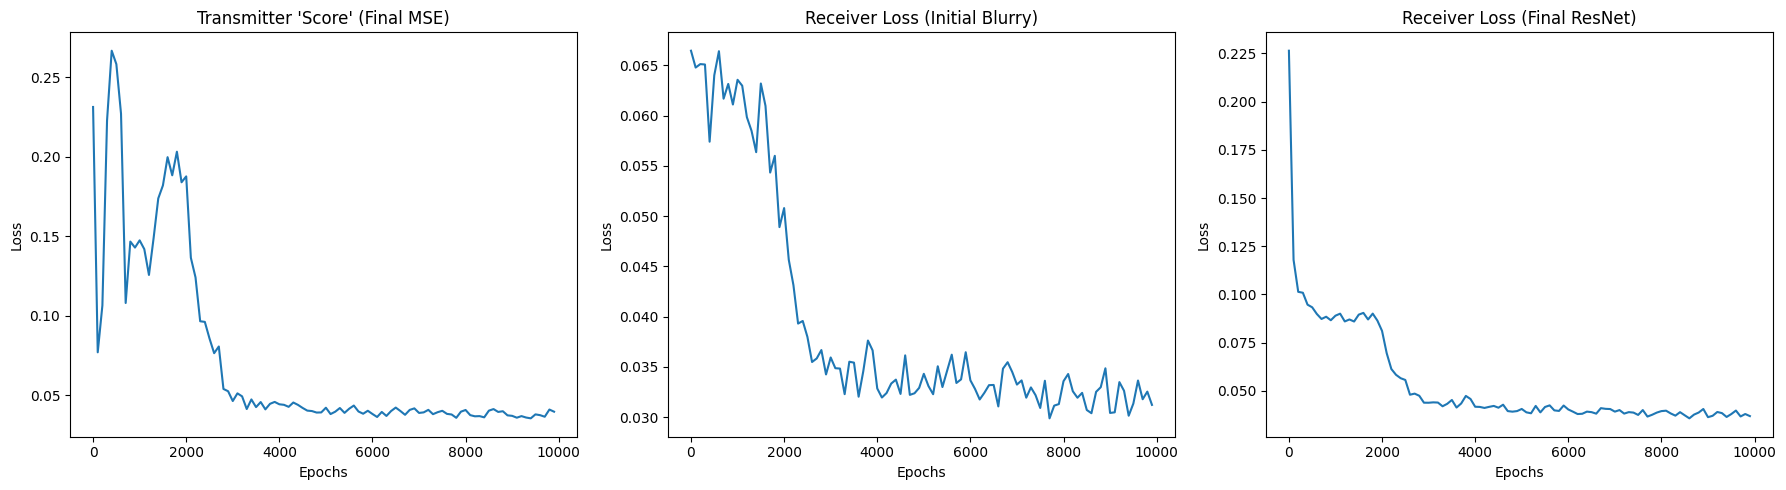

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv



print("\n--- Running Final Prediction and Visualization ---")
print("--- Using models currently in notebook memory... ---")


test_idx = np.random.randint(0, image_dataset_norm.shape[0], 10)
test_images = image_dataset_norm[test_idx]


test_signal = model_x(test_images, training=False)
test_received_signal = tf_channel_uwa(test_signal)
reconstructed_images_list = model_receiver(test_received_signal, training=False)


reconstructed_initial = reconstructed_images_list[0].numpy()
reconstructed_final = reconstructed_images_list[1].numpy()

print("--- Images reconstructed. Plotting... ---")



y_true_tf = tf.convert_to_tensor(test_images, dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(reconstructed_final, dtype=tf.float32)

print(f"\n--- Similarity for this batch (10 images) ---")


batch_mse = tf.reduce_mean(tf.square(y_true_tf - y_pred_tf))
print(f"  Mean Squared Error (MSE):   {batch_mse:.6f} (Lower is better)")


batch_psnr = tf.reduce_mean(tf.image.psnr(y_true_tf, y_pred_tf, max_val=1.0))
print(f"  PSNR (Peak Signal-to-Noise): {batch_psnr:.2f} dB (Higher is better)")


batch_ssim = tf.reduce_mean(tf.image.ssim(y_true_tf, y_pred_tf, max_val=1.0))
print(f"  Structural Similarity (SSIM): {batch_ssim:.6f} (Higher is better)")
print("--------------------------------------------------")



n = 10
plt.figure(figsize=(20, 6)) 
for i in range(n):
    
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructed_initial[i])
    plt.title("Initial (Blurry)")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    ax = plt.subplot(3, n, i + 1 + (n*2))
    plt.imshow(reconstructed_final[i])
    plt.title("Final (ResNet)")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


print("\n--- Plotting Loss History from training_log.csv ---")


log_csv_path = "/kaggle/working/training_log.csv"
epochs_list = []
loss_tx_history = []
loss_rx_initial = []
loss_rx_final = []

try:
    with open(log_csv_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        header = next(csv_reader) 
        
        for row in csv_reader:
            epochs_list.append(int(row[0]))
            loss_tx_history.append(float(row[1]))
            loss_rx_initial.append(float(row[2]))
            loss_rx_final.append(float(row[3]))

    plt.figure(figsize=(18, 5))
    
   
    plt.subplot(1, 3, 1)
    plt.plot(epochs_list, loss_tx_history)
    plt.title("Transmitter 'Score' (Final MSE)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    
    plt.subplot(1, 3, 2)
    plt.plot(epochs_list, loss_rx_initial)
    plt.title("Receiver Loss (Initial Blurry)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs_list, loss_rx_final)
    plt.title("Receiver Loss (Final ResNet)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"--- ERROR: Could not plot loss history from CSV. --- {e}")
    print(f"--- (Did you run the training cell first?) ---")